<a href="https://colab.research.google.com/github/WebDev-Alex/ProiectIAPI/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**!! Codul nu functioneaza in github collab !!**<br>

---

Blocheaza sesiunea, nu stiu de ce. Trebuie rulat local. Eu am facut si rulat proiectul in Spyder, dar orice IDE trebuie sa fie ok

# Scanner de documente cu OpenCV
**Autor:** Tușinean Alexandru Gabriel  
**Curs:** Inteligență Artificială în Prelucrarea Imaginilor

Acest proiect implementează un *document scanner* folosind tehnici clasice de procesare a imaginilor (OpenCV):
- detecție contururi (Canny) + morfologie
- selecția celui mai mare dreptunghi (pagina)
- corecție de perspectivă (warp)


In [ ]:
!pip -q install opencv-python ipywidgets reportlab
from google.colab.patches import cv2_imshow
from google.colab import files
import ipywidgets as widgets
import numpy as np, cv2, os, io, zipfile, sys
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

In [ ]:
USE_CAMERA = True
CAM_INDEX = 0

def disable_camera_in_colab():
    if 'google.colab' in sys.modules:
        print("Google Colab detectat → camera este dezactivată.")
        return True
    return False

if disable_camera_in_colab():
    USE_CAMERA = False


Google Colab detectat → camera este dezactivată.


In [ ]:
import cv2, numpy as np

def stackImages(imgArray, scale, lables=[]):
    rows, cols = len(imgArray), len(imgArray[0])
    isGrid = isinstance(imgArray[0], list)
    if isGrid:
        for r in range(rows):
            for c in range(cols):
                im = cv2.resize(imgArray[r][c], (0,0), fx=scale, fy=scale)
                if im.ndim == 2: im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
                imgArray[r][c] = im
        ver = np.vstack([np.hstack(r) for r in imgArray])
    else:
        ver = np.hstack([cv2.cvtColor(cv2.resize(i,(0,0),fx=scale,fy=scale),
                        cv2.COLOR_GRAY2BGR) if i.ndim==2 else
                        cv2.resize(i,(0,0),fx=scale,fy=scale) for i in imgArray])
    if lables:
        h, w = ver.shape[:2]
        ch, cw = h//rows, w//cols
        for r in range(rows):
            for c in range(cols):
                if r < len(lables) and c < len(lables[r]):
                    t = lables[r][c]; x,y = c*cw, r*ch
                    cv2.rectangle(ver,(x,y),(x+cw,y+30),(255,255,255),cv2.FILLED)
                    cv2.putText(ver,t,(x+10,y+20),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2)
    return ver

def reorder(pts):
    pts=pts.reshape((4,2))
    out=np.zeros((4,1,2),dtype=np.int32)
    s=pts.sum(1); d=np.diff(pts,axis=1)
    out[0]=pts[np.argmin(s)]; out[3]=pts[np.argmax(s)]
    out[1]=pts[np.argmin(d)]; out[2]=pts[np.argmax(d)]
    return out

def biggestContour(contours):
    best,area=np.array([]),0
    for c in contours:
        a=cv2.contourArea(c)
        if a>5000:
            peri=cv2.arcLength(c,True)
            approx=cv2.approxPolyDP(c,0.02*peri,True)
            if len(approx)==4 and a>area: best,area=approx,a
    return best,area

def drawRectangle(img,pts,t=2,color=(255,0,0)):
    p=pts.reshape(4,2)
    for i in [(0,1),(0,2),(3,2),(3,1)]:
        cv2.line(img,tuple(p[i[0]]),tuple(p[i[1]]),color,t)
    return img

def illumination_fix(gray,sigma=21):
    bg=cv2.GaussianBlur(gray,(0,0),sigmaX=sigma,sigmaY=sigma)
    norm=cv2.addWeighted(gray,1.5,bg,-0.5,0)
    norm=cv2.normalize(norm,None,0,255,cv2.NORM_MINMAX)
    return cv2.medianBlur(norm,3)


In [ ]:
def detect_and_warp(img_bgr, t1=200, t2=200, crop=20):
    target=(480,640)
    img=cv2.resize(img_bgr,target)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur=cv2.GaussianBlur(gray,(5,5),1)
    edges=cv2.Canny(blur,t1,t2)
    k=np.ones((5,5),np.uint8)
    mask=cv2.erode(cv2.dilate(edges,k,2),k,1)
    cnts,_=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    visC,visB=img.copy(),img.copy()
    cv2.drawContours(visC,cnts,-1,(0,255,0),3)
    biggest,_=biggestContour(cnts)
    warped=grayWarp=None;scan=None
    if biggest.size!=0:
        biggest=reorder(biggest)
        drawRectangle(visB,biggest,2,(255,0,0))
        src=np.float32(biggest)
        dst=np.float32([[0,0],[target[0],0],[0,target[1]],[target[0],target[1]]])
        M=cv2.getPerspectiveTransform(src,dst)
        warped=cv2.warpPerspective(img,M,target)
        warped=warped[crop:warped.shape[1]-crop,crop:warped.shape[0]-crop]
        warped=cv2.resize(warped,target)
        grayWarp=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
        norm=illumination_fix(grayWarp)
        scan=cv2.adaptiveThreshold(norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,10)
        scan=cv2.morphologyEx(scan,cv2.MORPH_OPEN,np.ones((3,3),np.uint8),1)
    tiles=([img,gray,edges,visC],[visB,warped if warped is not None else np.zeros_like(img),
           grayWarp if grayWarp is not None else np.zeros_like(gray),
           scan if scan is not None else np.zeros_like(gray)])
    labels=[["Original","Gray","Edges","Contours"],
            ["Biggest","Warp","WarpGray","Scan"]]
    return stackImages(tiles,0.9,labels),warped,scan


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

→ 1.jpg


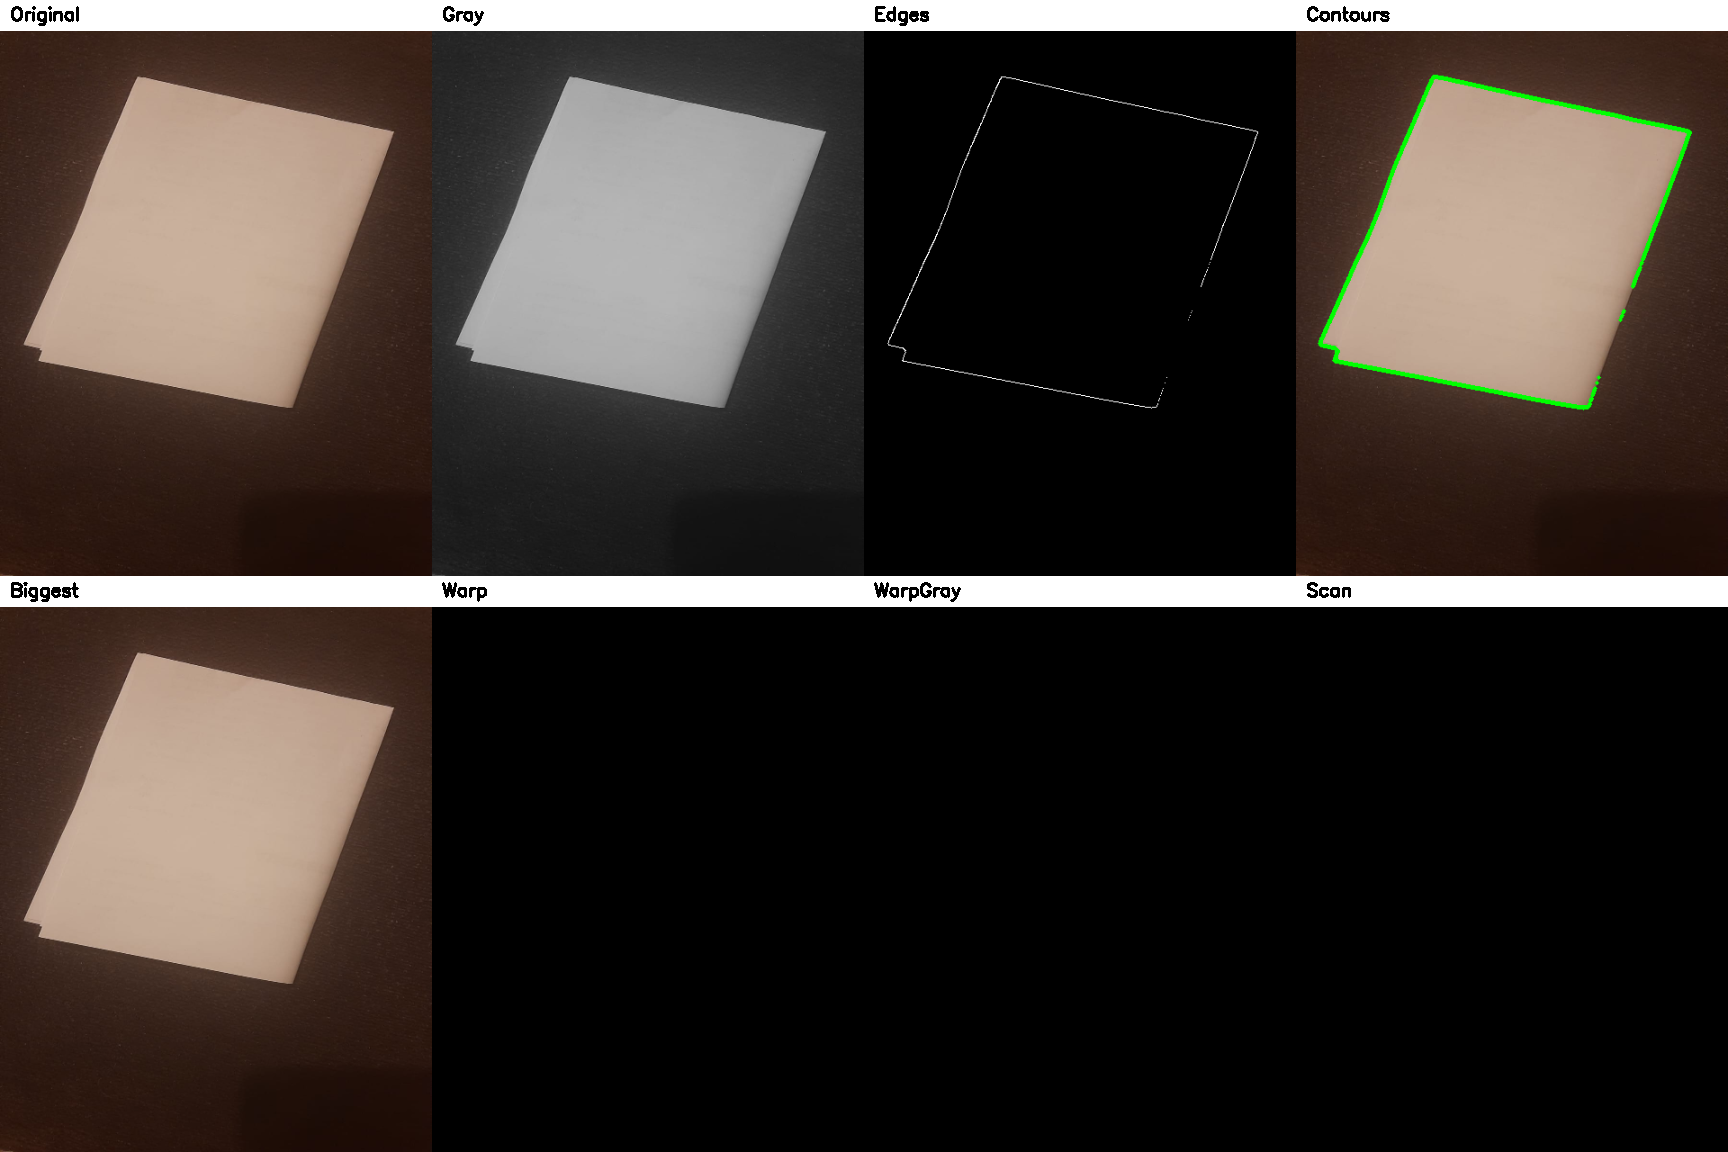

→ 5f5efe23-bf07-4322-95c7-7678bc701a7e.jpg


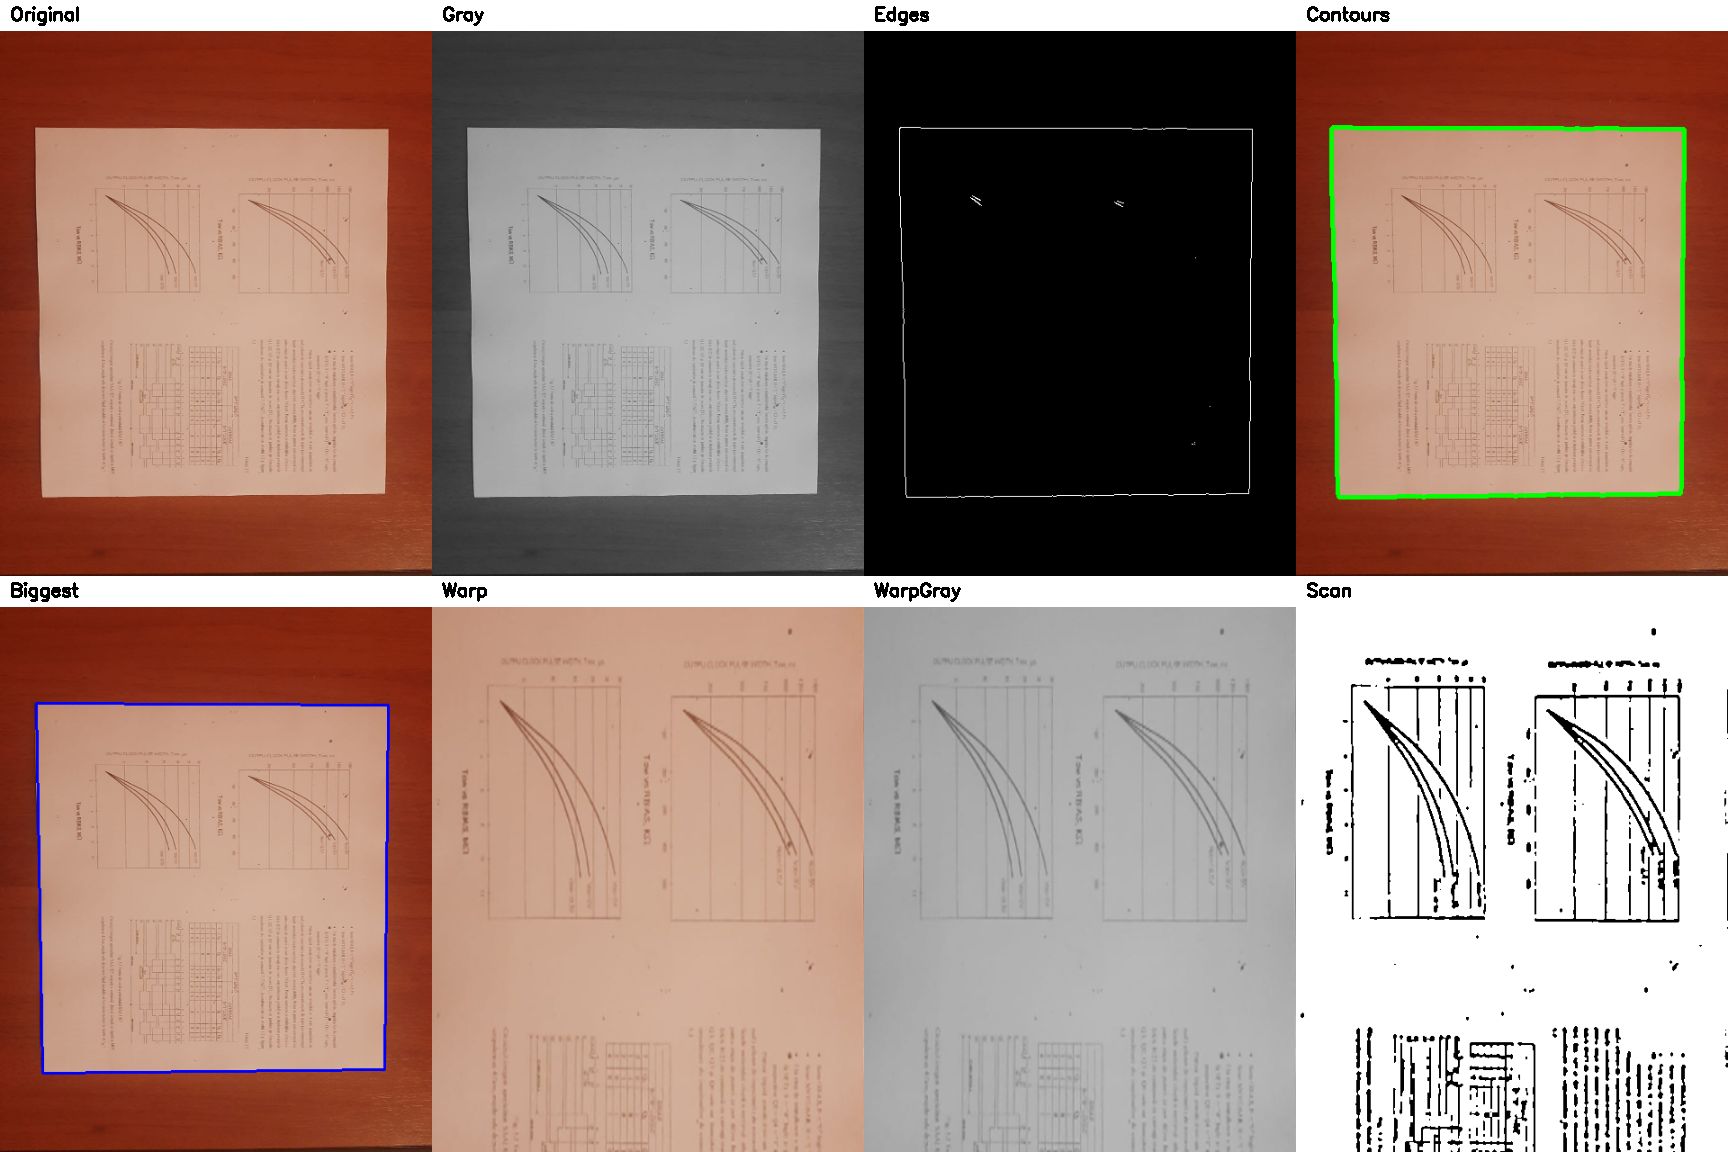

In [ ]:
thr1 = widgets.IntSlider(value=200,min=0,max=255,description='Threshold1')
thr2 = widgets.IntSlider(value=200,min=0,max=255,description='Threshold2')
display(widgets.HBox([thr1,thr2]))

upload = widgets.FileUpload(accept='image/*', multiple=True)
display(upload)
os.makedirs("scans", exist_ok=True)

def process_upload(change=None):
    if not upload.value:
        print("Încarcă imagini...")
        return
    for name,item in upload.value.items():
        data=np.frombuffer(item['content'],np.uint8)
        img=cv2.imdecode(data,cv2.IMREAD_COLOR)
        canvas,warped,scan=detect_and_warp(img,thr1.value,thr2.value,20)
        print("→",name)
        cv2_imshow(canvas)
        base,_=os.path.splitext(name)
        if warped is not None: cv2.imwrite(f"scans/{base}_warped.jpg",warped)
        if scan   is not None: cv2.imwrite(f"scans/{base}_scan.png",scan)
upload.observe(process_upload,names='value')


In [ ]:
def run_camera_local(t1=200,t2=200,cam_index=0):
    cap=cv2.VideoCapture(cam_index)
    if not cap.isOpened():
        print("Camera indisponibilă.");return
    os.makedirs("scans",exist_ok=True)
    c=0
    print("Apasă S pt salvare, Q pt ieșire.")
    while True:
        ok,frame=cap.read()
        if not ok: break
        canvas,w,s=detect_and_warp(frame,t1,t2,20)
        cv2.imshow("Scanner",canvas)
        k=cv2.waitKey(1)&0xFF
        if k in (27,ord('q')):break
        if k==ord('s') and w is not None:
            path=f"scans/cam_{c}.jpg";cv2.imwrite(path,w);print("Salvat:",path);c+=1
    cap.release();cv2.destroyAllWindows()


In [ ]:
def export_zip_pdf(src='scans', pdf_out='scans_output.pdf'):
    imgs=[f for f in sorted(os.listdir(src)) if f.endswith(('.jpg','.png'))]
    if not imgs:
        print("Nu există fișiere scanate.")
        return
    # ZIP
    with zipfile.ZipFile('scans.zip','w',zipfile.ZIP_DEFLATED) as z:
        for f in imgs: z.write(os.path.join(src,f),arcname=f)
    files.download('scans.zip')

    # PDF
    c=canvas.Canvas(pdf_out,pagesize=A4);W,H=A4
    for f in imgs:
        im=Image.open(os.path.join(src,f)).convert("RGB")
        im.thumbnail((int(W),int(H)),Image.LANCZOS)
        tmp=f+".bmp";im.save(tmp)
        c.drawImage(tmp,0,0,width=W,height=H);c.showPage();os.remove(tmp)
    c.save();files.download(pdf_out)
    print("Export complet.")

export_zip_pdf()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export complet.
